In [1]:
# ===========================
# IMPORTS & CONFIG
# ===========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib

plt.style.use("ggplot")
sns.set_context("talk")

print("Imports OK ✔️")


Imports OK ✔️


In [2]:
# ===========================
# LOAD DATASET
# ===========================
df = pd.read_csv("../app/data/IoT_Indoor_Air_Quality_Dataset.csv")
print("Dataset chargé ✔️")
print("Aperçu des 5 premières lignes :")
display(df.head())
print("\nInformations générales :")
print(df.info())


Dataset chargé ✔️
Aperçu des 5 premières lignes :


,Timestamp,Temperature (?C),Humidity (%),CO2 (ppm),PM2.5 (?g/m?),PM10 (?g/m?),TVOC (ppb),CO (ppm),Light Intensity (lux),Motion Detected,Occupancy Count,Ventilation Status
0,18-02-2024 08:00,21.75,63.11,989.74,31.17,89.66,226.83,2.84,646.86,0.0,49.0,Open
1,18-02-2024 08:05,27.51,68.03,924.59,27.32,44.82,116.76,3.12,845.45,1.0,11.0,Open
2,18-02-2024 08:10,25.32,53.51,604.05,73.84,71.08,56.59,3.59,560.03,1.0,29.0,Closed
3,18-02-2024 08:15,23.99,58.52,692.20,62.94,10.90,228.06,2.66,499.84,1.0,28.0,Closed
4,18-02-2024 08:20,19.56,69.34,533.12,26.56,88.06,267.26,1.76,411.36,1.0,16.0,Closed



Informations générales :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97458 entries, 0 to 97457
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Timestamp              97458 non-null  object 
 1   Temperature (?C)       95509 non-null  float64
 2   Humidity (%)           95509 non-null  float64
 3   CO2 (ppm)              95509 non-null  float64
 4   PM2.5 (?g/m?)          95509 non-null  float64
 5   PM10 (?g/m?)           95509 non-null  float64
 6   TVOC (ppb)             95509 non-null  float64
 7   CO (ppm)               95509 non-null  float64
 8   Light Intensity (lux)  95509 non-null  float64
 9   Motion Detected        95509 non-null  float64
 10  Occupancy Count        95509 non-null  float64
 11  Ventilation Status     95509 non-null  object 
dtypes: float64(10), object(2)
memory usage: 8.9+ MB
None


In [3]:
# ===========================
# CLEANING & PREPROCESSING
# ===========================
print("🔧 Nettoyage...")

# Conversion Timestamp
df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce", dayfirst=True)
df = df.dropna(subset=["Timestamp"])
print("✔️ Timestamp nettoyé")

# Suppression des valeurs aberrantes sur les capteurs (IQR)
numeric_cols = ["Temperature (?C)", "Humidity (%)", "CO2 (ppm)",
                "PM2.5 (?g/m?)", "PM10 (?g/m?)", "TVOC (ppb)", "CO (ppm)",
                "Light Intensity (lux)", "Motion Detected", "Occupancy Count"]

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    df = df[(df[col] >= lower) & (df[col] <= upper)]

print("✔️ Valeurs aberrantes supprimées")

# Création d'un label binaire Ventilation_Recommended basé sur règles OMS
# (Exemple : ventilation recommandée si CO2 > 1000 ppm ou PM2.5 > 35 ou PM10 > 50)
df["Ventilation_Recommended"] = ((df["CO2 (ppm)"] > 1000) | 
                                 (df["PM2.5 (?g/m?)"] > 35) | 
                                 (df["PM10 (?g/m?)"] > 50)).astype(int)

print("✔️ Colonne 'Ventilation_Recommended' créée")
print("\nDistribution :")
print(df["Ventilation_Recommended"].value_counts(normalize=True))



🔧 Nettoyage...
✔️ Timestamp nettoyé
✔️ Valeurs aberrantes supprimées
✔️ Colonne 'Ventilation_Recommended' créée

Distribution :
Ventilation_Recommended
1    0.811418
0    0.188582
Name: proportion, dtype: float64


In [4]:
# ===========================
# FEATURE ENGINEERING
# ===========================
# On garde les features utiles + Température / Humidité
features = ["Temperature (?C)", "Humidity (%)", "CO2 (ppm)",
            "PM2.5 (?g/m?)", "PM10 (?g/m?)", "TVOC (ppb)", "CO (ppm)",
            "Light Intensity (lux)", "Motion Detected", "Occupancy Count"]

target = "Ventilation_Recommended"

X = df[features]
y = df[target]

print("Variables sélectionnées ✔️")
print("X shape :", X.shape)
print("y shape :", y.shape)


Variables sélectionnées ✔️
X shape : (79610, 10)
y shape : (79610,)


<Figure size 1600x600 with 0 Axes>

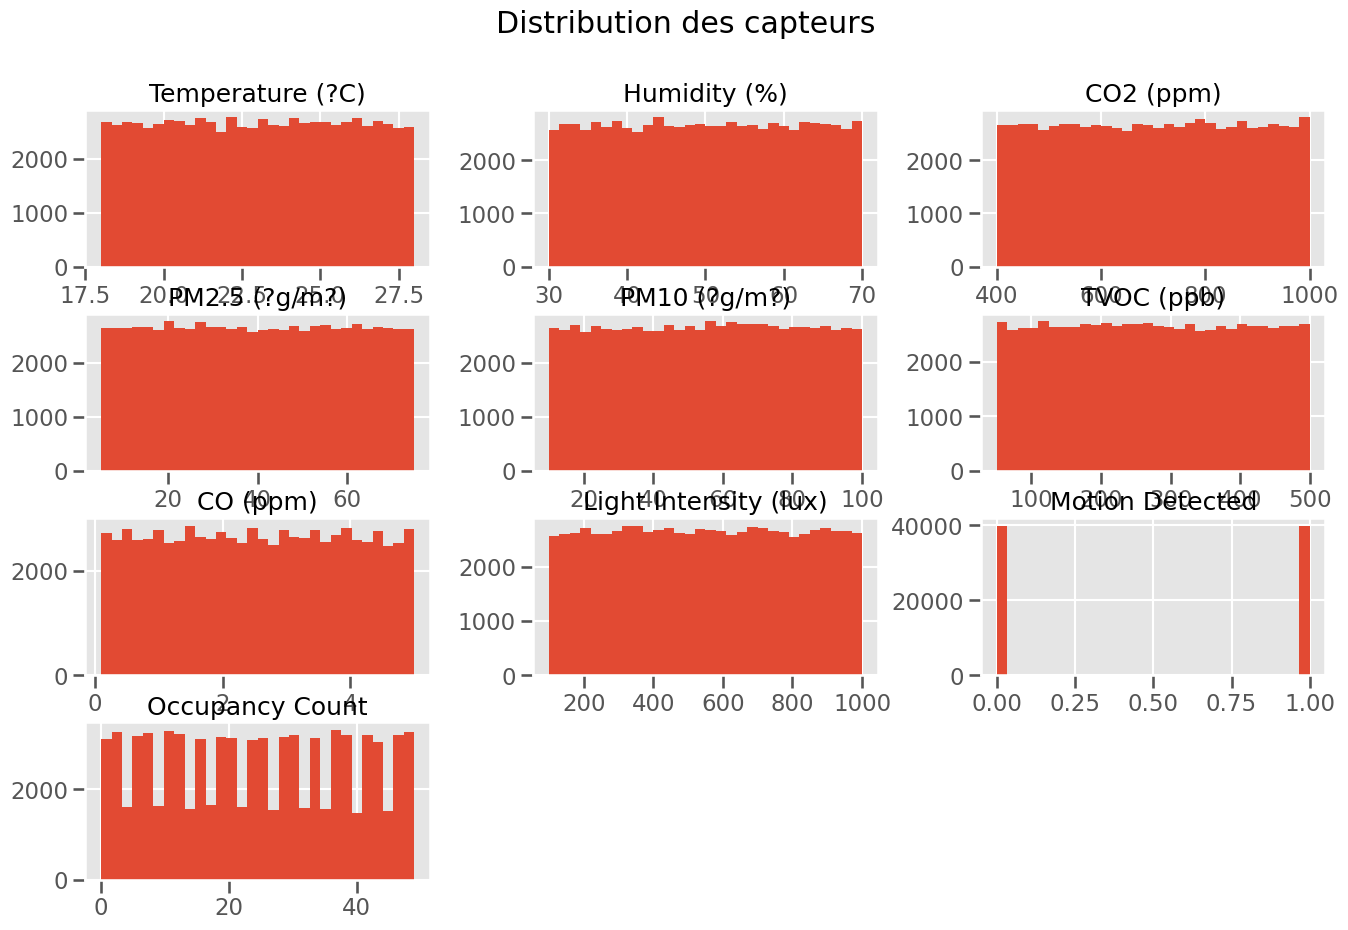

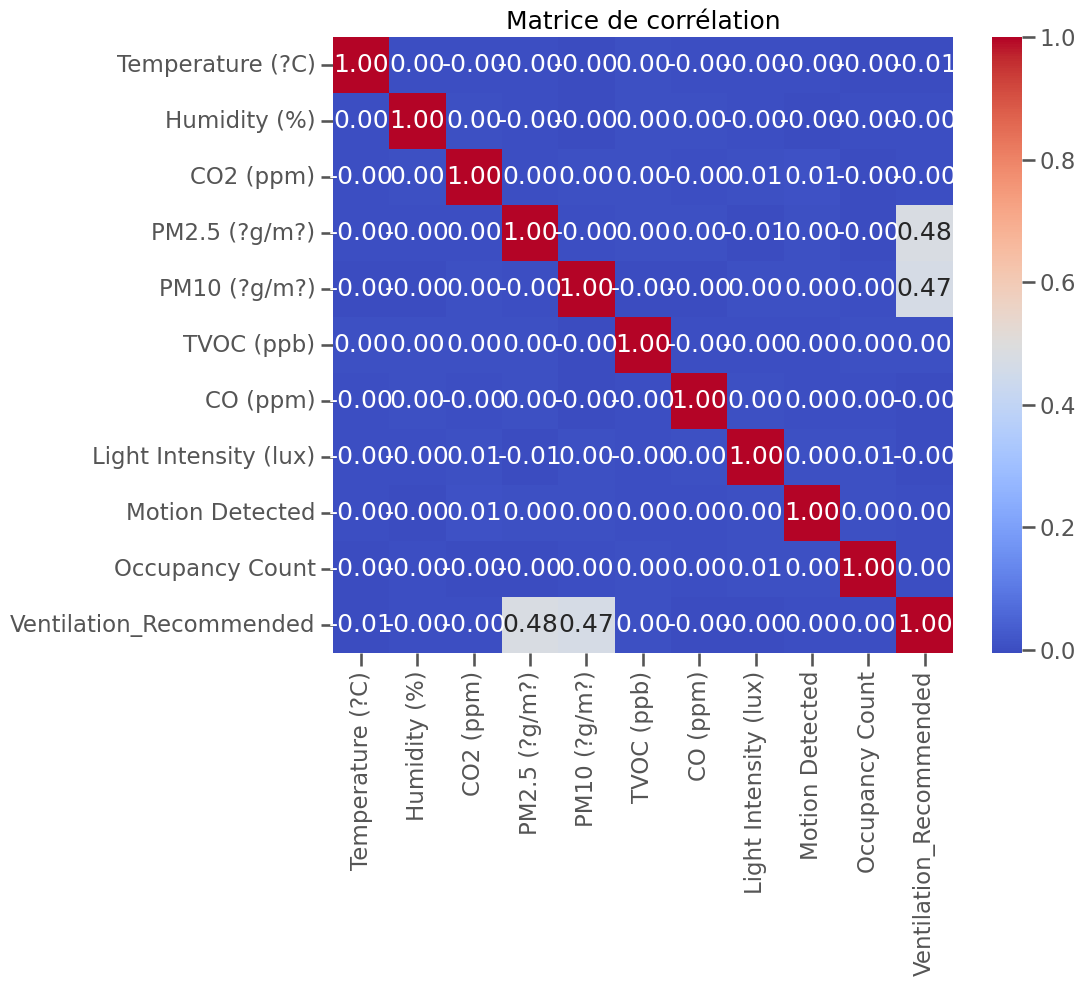

In [5]:
# ===========================
# EXPLORATORY DATA ANALYSIS
# ===========================
# Histogrammes et boxplots
plt.figure(figsize=(16, 6))
df[features].hist(bins=30, figsize=(16,10))
plt.suptitle("Distribution des capteurs")
plt.show()

# Heatmap de corrélation
corr = df[features + [target]].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matrice de corrélation")
plt.show()


In [6]:
# ===========================
# TRAIN / TEST SPLIT
# ===========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\n✔️ Données séparées")
print("Taille train :", X_train.shape)
print("Taille test :", X_test.shape)
print("\nRépartition des classes dans y_train :")
print(y_train.value_counts(normalize=True))


✔️ Données séparées
Taille train : (63688, 10)
Taille test : (15922, 10)

Répartition des classes dans y_train :
Ventilation_Recommended
1    0.811424
0    0.188576
Name: proportion, dtype: float64


In [7]:
# ===========================
# MODEL TRAINING
# ===========================
model = RandomForestClassifier(
    n_estimators=400,
    max_depth=14,
    class_weight="balanced",
    random_state=42
)

print("⏳ Entraînement du modèle...")
model.fit(X_train, y_train)
print("✔️ Modèle entraîné")


⏳ Entraînement du modèle...
✔️ Modèle entraîné


📊 Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3003
           1       1.00      1.00      1.00     12919

    accuracy                           1.00     15922
   macro avg       1.00      1.00      1.00     15922
weighted avg       1.00      1.00      1.00     15922


📉 Matrice de confusion :


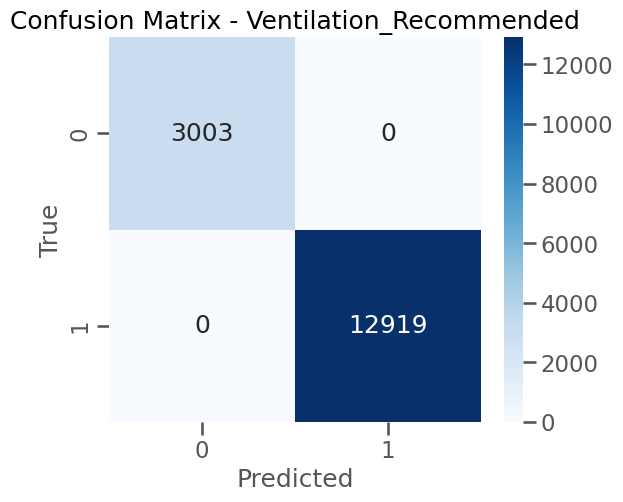

In [8]:
# ===========================
# EVALUATION
# ===========================
y_pred = model.predict(X_test)

print("📊 Rapport de classification :")
print(classification_report(y_test, y_pred))

print("\n📉 Matrice de confusion :")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Ventilation_Recommended")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


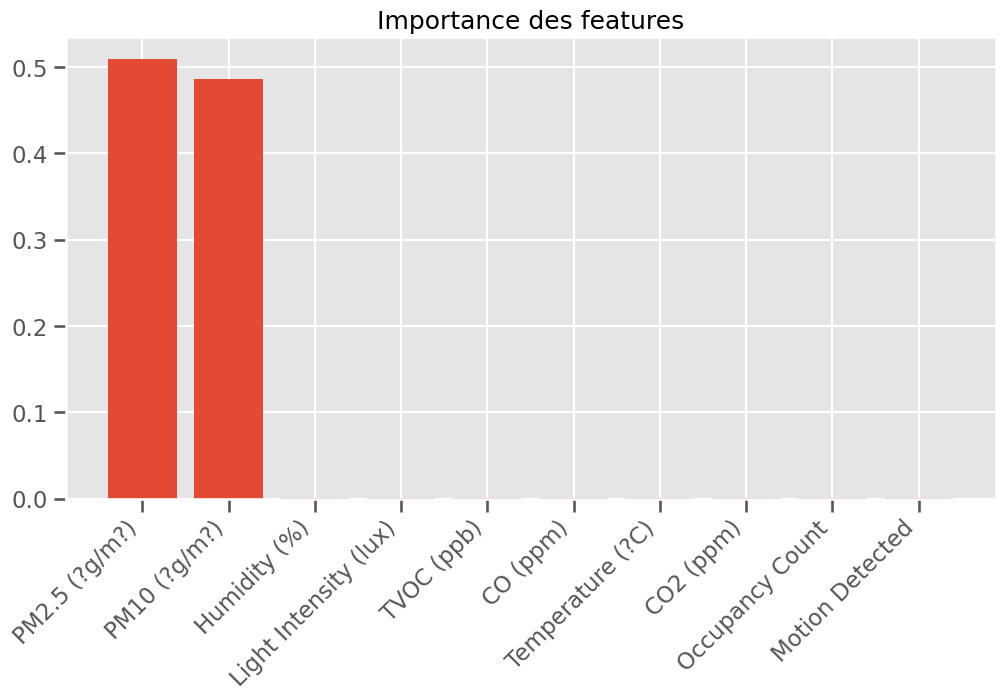

In [9]:
# ===========================
# FEATURE IMPORTANCE
# ===========================
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12,6))
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), np.array(features)[indices], rotation=45, ha="right")
plt.title("Importance des features")
plt.show()


In [10]:
# ===========================
# SAVE MODEL
# ===========================
joblib.dump(model, "ventilation_predictor_oms.pkl")
print("✔️ Modèle sauvegardé sous 'ventilation_predictor_oms.pkl'")


✔️ Modèle sauvegardé sous 'ventilation_predictor_oms.pkl'


In [11]:
# ===========================
# TESTS DU MODELE (EXEMPLES)
# ===========================
tests = {
    "Ventilation doit être ON": {
        "Temperature (?C)": 25.8, "Humidity (%)": 72.0, "CO2 (ppm)": 1650,
        "PM2.5 (?g/m?)": 45.2, "PM10 (?g/m?)": 110.5, "TVOC (ppb)": 320,
        "CO (ppm)": 4.1, "Light Intensity (lux)": 530, "Motion Detected": 1, "Occupancy Count": 38
    },
    "Ventilation doit être OFF": {
        "Temperature (?C)": 21.0, "Humidity (%)": 45.5, "CO2 (ppm)": 450,
        "PM2.5 (?g/m?)": 5.1, "PM10 (?g/m?)": 10.4, "TVOC (ppb)": 40,
        "CO (ppm)": 0.5, "Light Intensity (lux)": 100, "Motion Detected": 0, "Occupancy Count": 0
    },
    "Cas borderline": {
        "Temperature (?C)": 24.3, "Humidity (%)": 61.2, "CO2 (ppm)": 980,
        "PM2.5 (?g/m?)": 25.5, "PM10 (?g/m?)": 50.2, "TVOC (ppb)": 150,
        "CO (ppm)": 2.0, "Light Intensity (lux)": 350, "Motion Detected": 1, "Occupancy Count": 9
    },
    "Cas ambigu": {
        "Temperature (?C)": 27.0, "Humidity (%)": 69.0, "CO2 (ppm)": 1200,
        "PM2.5 (?g/m?)": 12.5, "PM10 (?g/m?)": 20.0, "TVOC (ppb)": 90,
        "CO (ppm)": 1.5, "Light Intensity (lux)": 900, "Motion Detected": 1, "Occupancy Count": 2
    }
}

LABELS = {0: "OFF", 1: "ON"}

model = joblib.load("ventilation_predictor_oms.pkl")
print("✔️ Modèle chargé")

for title, example in tests.items():
    df_ex = pd.DataFrame([example])
    pred = model.predict(df_ex)[0]
    print(f"----- {title} -----")
    display(df_ex)
    print(f"➡️ Prédiction : {LABELS[pred]}")
    print("------------------------------\n")


✔️ Modèle chargé
----- Ventilation doit être ON -----


,Temperature (?C),Humidity (%),CO2 (ppm),PM2.5 (?g/m?),PM10 (?g/m?),TVOC (ppb),CO (ppm),Light Intensity (lux),Motion Detected,Occupancy Count
0,25.8,72.0,1650,45.2,110.5,320,4.1,530,1,38


➡️ Prédiction : ON
------------------------------

----- Ventilation doit être OFF -----


,Temperature (?C),Humidity (%),CO2 (ppm),PM2.5 (?g/m?),PM10 (?g/m?),TVOC (ppb),CO (ppm),Light Intensity (lux),Motion Detected,Occupancy Count
0,21.0,45.5,450,5.1,10.4,40,0.5,100,0,0


➡️ Prédiction : OFF
------------------------------

----- Cas borderline -----


,Temperature (?C),Humidity (%),CO2 (ppm),PM2.5 (?g/m?),PM10 (?g/m?),TVOC (ppb),CO (ppm),Light Intensity (lux),Motion Detected,Occupancy Count
0,24.3,61.2,980,25.5,50.2,150,2.0,350,1,9


➡️ Prédiction : ON
------------------------------

----- Cas ambigu -----


,Temperature (?C),Humidity (%),CO2 (ppm),PM2.5 (?g/m?),PM10 (?g/m?),TVOC (ppb),CO (ppm),Light Intensity (lux),Motion Detected,Occupancy Count
0,27.0,69.0,1200,12.5,20.0,90,1.5,900,1,2


➡️ Prédiction : OFF
------------------------------

